# BDA ANALYSEPROJEKT MIETPREISE DEUTSCHLAND 2023


## Betriebswirtschaftliche Datenanalyse – Exposé

### Teammitglieder

| Vorname   | Nachname  | Matrikelnummer |
|-----------|-----------|----------------|
| Timon     | Schmidt   | 217101         |
| Sümeyye   | Gügercin  | 214424         |
| Melih     | Akbulut   | 220860         |
| Dariana   | Barkov    | 220858         |
| Rasmus    | Wegat     | 221727         |

---

### Fragestellung

**„Gibt es einen klaren Zusammenhang zwischen Leerstand und Mietpreisen in Deutschland?“**

---

### Erläuterung

In dieser Analyse sollen die Daten zu leerstehenden Wohnungen und den Wohnungspreisen in den jeweiligen Landkreisen aus dem Jahr 2023 verglichen werden. Ziel ist es, zu untersuchen, ob in attraktiven Städten mit hohen Mieten ein künstlicher Wohnungsleerstand existiert, um durch eine künstliche Verknappung die Preise hochzuhalten. Darüber hinaus sollen weitere Muster identifiziert werden, um die Haupttreiber hoher Mietpreise in Großstädten besser zu verstehen.

---

### Ansatz und Vorgehensweise

Mit Hilfe von **pandas**, **matplotlib** und **seaborn** werden die Leerstandsquoten und Mietpreise auf Kreisebene anhand der Daten des Deutschlandatlas analysiert und visualisiert. Zusätzlich können weitere Einflussfaktoren wie Bevölkerungsdichte, Einkommen und Urbanität einbezogen werden, um weitere Aussagen über Ursachen hoher Mietpreise treffen zu können.

---

### Datenquelle

[Deutschlandatlas – Mieten](https://www.deutschlandatlas.bund.de/DE/Karten/Wie-wir-wohnen/040-Mieten.html#_g5f1sd6f4)  
Aufgerufen am 13.04.2025, 13:00 Uhr.

Imports

In [7]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import seaborn as sns
from scipy.stats import lognorm, kstest, norm, shapiro, zscore

%matplotlib inline

Einlesen der Exel Datei und herausfiltern der Daten die wir wollen


In [8]:

gem1222 = pd.read_excel("Deutschlandatlas-Daten.xlsx", sheet_name="Deutschlandatlas_GEM1222")
vbgem1222 = pd.read_excel("Deutschlandatlas-Daten.xlsx", sheet_name="Deutschlandatlas_VBGEM1222")
krs1222 = pd.read_excel("Deutschlandatlas-Daten.xlsx", sheet_name="Deutschlandatlas_KRS1222")
krs1221 = pd.read_excel("Deutschlandatlas-Daten.xlsx", sheet_name="Deutschlandatlas_KRS1221")
krs1220 = pd.read_excel("Deutschlandatlas-Daten.xlsx", sheet_name="Deutschlandatlas_KRS1220")
def rename_key(df):
    return df.rename(columns={df.columns[0]: "KRS_ID"})

gem1222 = rename_key(gem1222)
vbgem1222 = rename_key(vbgem1222)
krs1222 = rename_key(krs1222)
krs1221 = rename_key(krs1221)
krs1220 = rename_key(krs1220)

gem_cols = ["KRS_ID", "Gemeindename", "bev_dicht", "bev_entw", "beschq_insg"]
vbgem_cols = ["KRS_ID", "Gemeindeverbandsname", "pendel"]
krs1222_cols = ["KRS_ID", "Kreisname", "bev_binw", "preis_miet", "wohn_eigen", "wohn_leer", "wohn_EZFH", "wohn_MFH",
                "erw_wachs", "erw_mini", "erw_minineben", "alq", "schulden", "sozsich", "straft", "einbr"]
krs1221_cols = ["KRS_ID", "Kreisname", "preis_baul", "erw_bip", "hh_veink"]
krs1220_cols = ["KRS_ID", "Kreisname", "erw_vol"]

gem1222_sel = gem1222[gem_cols]
vbgem1222_sel = vbgem1222[vbgem_cols]
krs1222_sel = krs1222[krs1222_cols]
krs1221_sel = krs1221[krs1221_cols]
krs1220_sel = krs1220[krs1220_cols]

df = krs1222_sel.merge(krs1221_sel, on=["KRS_ID", "Kreisname"], how="left", suffixes=("", "_krs1221"))
df = df.merge(krs1220_sel, on=["KRS_ID", "Kreisname"], how="left", suffixes=("", "_krs1220"))
df = df.merge(vbgem1222_sel, on="KRS_ID", how="left")
df = df.merge(gem1222_sel, on="KRS_ID", how="left")

df = df.sort_values("KRS_ID").reset_index(drop=True)
df.to_excel("ExtractedData.xlsx", index=False)


**Legende der Kombinierten Tabelle**

- **bev_dicht**: Bevölkerungsdichte (Einwohner je km²)
- **bev_entw**: Bevölkerungsentwicklung (% zum Vorjahr)
- **beschq_insg**: Beschäftigungsquote insgesamt (%)
- **pendel**: Pendleranteil bzw. Pendlerbewegung
- **bev_binw**: Bevölkerungsentwicklung insgesamt (%-Veränderung)
- **preis_miet**: Angebotsmietpreis in €/m²
- **wohn_eigen**: Anteil der selbstgenutzten Immobilien (%)
- **wohn_leer**: Leerstandsquote (%)
- **wohn_EZFH**: Anteil an Ein- und Zweifamilienhäusern (%)
- **wohn_MFH**: Anteil an Mehrfamilienhäusern (%)
- **erw_wachs**: Erwerbstätigenwachstum (%)
- **erw_mini**: Anteil der Minijobs (%)
- **erw_minineben**: Anteil der Minijobs als Nebentätigkeit (%)
- **alq**: Arbeitslosenquote (%)
- **schulden**: Verschuldung je Einwohner (in €)
- **sozsich**: Anteil an der Bevölkerung in sozialer Sicherung (%)
- **straft**: Straftaten pro 100.000 Einwohner
- **einbr**: Einbruchshäufigkeit pro 100.000 Einwohner
- **preis_baul**: Baulandpreise (Textkategorie, z. B. „100 bis unter 200 €/m²“)
- **erw_bip**: Bruttoinlandsprodukt (BIP) je Erwerbstätigen (in Tsd. €)
- **hh_veink**: Verfügbares Einkommen je Einwohner (in Tsd. €)
- **erw_vol**: Anteil der Vollzeit-Erwerbstätigen an allen Erwerbstätigen (%)

## 1. Der Zusammenhang von Leerstand und Mietpreisen

**Gibt es einen direkten Zusammenhang Zwischen Leerstand und Mietpreisen von Wohnungen?**

- Scatterpolt und Trendline
- Korrelationsanalyse (Pearson/Spearman)
- Regionale Ausreißer


In [15]:
preis_miet_order = [
	"bis unter 5,50",
	"5,50 bis unter 7,00",
	"7,00 bis unter 8,50",
	"8,50 bis unter 10,00",
	"10,00 bis unter 11,50",
	"11,50 und mehr"
]
df['preis_miet_cat'] = pd.Categorical(df['preis_miet'], categories=preis_miet_order, ordered=True)

In [19]:
df['preis_miet'].value_counts().reindex(preis_miet_order[::-1]).rename('Anzahl').rename_axis('Mietpreiskategorie').reset_index()

,Mietpreiskategorie,Anzahl
0,"11,50 und mehr",46
1,"10,00 bis unter 11,50",59
2,"8,50 bis unter 10,00",101
3,"7,00 bis unter 8,50",122
4,"5,50 bis unter 7,00",70
5,"bis unter 5,50",2


In [44]:
anzahl = df['preis_miet'].value_counts().reindex(preis_miet_order)
print(f"Anzahl der Kreise: {len(df)}")
for seg, n in anzahl.items():
    prozent = n / len(df) * 100 if n is not None else 0
    print(f"{seg:<22}: {n:3} Kreise ({prozent:5.2f}%)")

Anzahl der Kreise: 400
bis unter 5,50        :   2 Kreise ( 0.50%)
5,50 bis unter 7,00   :  70 Kreise (17.50%)
7,00 bis unter 8,50   : 122 Kreise (30.50%)
8,50 bis unter 10,00  : 101 Kreise (25.25%)
10,00 bis unter 11,50 :  59 Kreise (14.75%)
11,50 und mehr        :  46 Kreise (11.50%)


**1.1 Wie hoch sind die Mieten in Deutschen Kreisen?**

Über die Hälfte (55,75%) aller Kreise befinden sich im mittleren Bereich zwischen 7,00 und 10,00 €. 46 Kreise überschreiten die Marke von 11,50 €, während extrem günstige Mieten mit unter 5,50 € nur noch in 2 Kreisen vorkommen. Das zeigt, dass zwar viele Regionen noch moderate Mieten haben, der besonders günstige Wohnraum aber fast vollständig verschwunden ist und hochpreisige Regionen zunehmen.

Zur Veranschaulichung der Verteilung der Mietpreise lassen diese sich in einem Diagramm mit Dichte-Overlay darstellen.

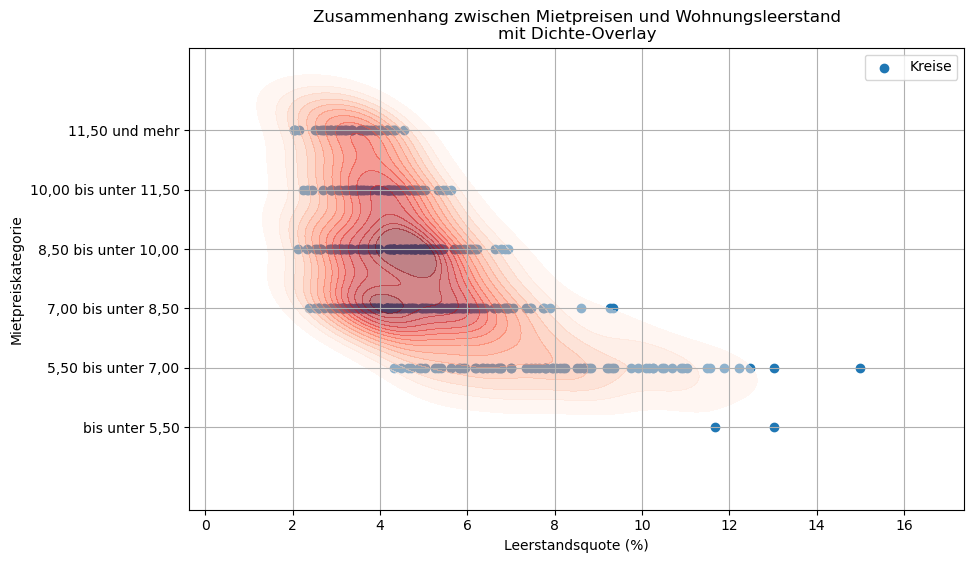

In [ ]:
x = df['wohn_leer']
y = df['preis_miet_cat'].cat.codes
plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=1, label='Kreise')
sns.kdeplot(x=x, y=y, cmap="Reds", fill=True, thresh=0.05, alpha=0.5, levels=15)
plt.xlabel('Leerstandsquote (%)')
plt.ylabel('Mietpreiskategorie')
plt.yticks(range(len(preis_miet_order)), preis_miet_order)
plt.title('Zusammenhang zwischen Mietpreisen und Wohnungsleerstand\nmit Dichte-Overlay')
plt.grid(True)
plt.legend()
plt.show()


**1.2 Interpretation der Datenverteilung**
    
Konträr zu der ursprünglichen Annahme das Mietpreise durch Künstliche Knappheit angehoben werden könnten, ist der Trend klar erkennbar, dass Mieten in jenen Kreisen höher sind, wo auch eine geringe Leerstandsquote herrscht. Völlig lässt sich dies dadurch nicht ausschließen, da in einzelfällen, dies immermoch die intention sein könnte, aber es wiederlegt eine Verbreitete Verwendung dieser Methode.

Um den zusammenhang klarer darzustellen lässt sich eine Regressionsgerade in diesem Diagramm zeichen. Dieser zusammenhang lässt sich auch Numerarisch nach Pearson und Spearman aufweisen.

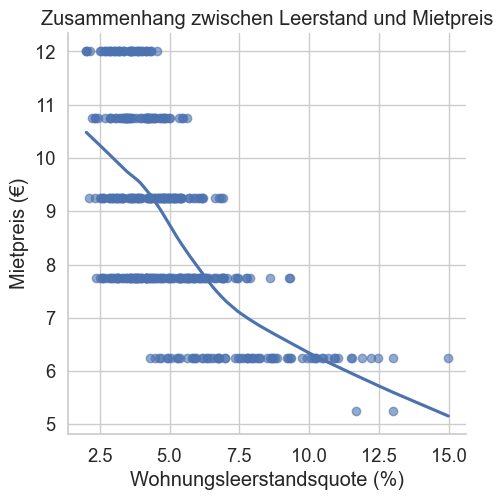

In [47]:
preis_map = {
    "bis unter 5,50": 5.25,
    "5,50 bis unter 7,00": 6.25,
    "7,00 bis unter 8,50": 7.75,
    "8,50 bis unter 10,00": 9.25,
    "10,00 bis unter 11,50": 10.75,
    "11,50 und mehr": 12.0
}
df['preis_miet_num'] = df['preis_miet'].map(preis_map)
sns.lmplot(x='wohn_leer', y='preis_miet_num', data=df, lowess=True, scatter_kws={'alpha':0.6})
plt.title('Zusammenhang zwischen Leerstand und Mietpreis')
plt.xlabel('Wohnungsleerstandsquote (%)')
plt.ylabel('Mietpreis (€)')
plt.show()

In [51]:
pearson_corr = df[['preis_miet_num', 'wohn_leer']].corr(method='pearson').iloc[0,1]
spearman_corr = df[['preis_miet_num', 'wohn_leer']].corr(method='spearman').iloc[0,1]
print(f"Pearson-Korrelation: {pearson_corr:.2f}")
print(f"Spearman-Korrelation: {spearman_corr:.2f}")

Pearson-Korrelation: -0.63
Spearman-Korrelation: -0.63


**1.3 Der Zusammenhang Beschrieben**

Es ist ein mittlerer bis stark negativer Zusammenhang zwischen Mietpreisen und der Leerstandssquote vorhanden. Die Tendenz ist bei höherer Leerstandsquote sind aus die Mieten niedriger und da sowohl die Spearman als auch Pearson Ergebnisse gleich sind ist der Zusammenhang robust gegenüber Ausreißern. Allerding ist klar das die hohen Mieten durch andere Faktoren stärker beieinflusst sind und diese müssen im weiteren analysiert werden.